Installing PyTorch Geometric

In [ ]:
!python -c "import torch; print(torch.version.cuda)"
!pip install -q torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install -q torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

11.8
ERROR: Could not find a version that satisfies the requirement torch-scatter==latest+cu101 (from versions: 0.3.0, 1.0.2, 1.0.3, 1.0.4, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.3.0, 1.3.1, 1.3.2, 1.4.0, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1)
ERROR: No matching distribution found for torch-scatter==latest+cu101
ERROR: Could not find a version that satisfies the requirement torch-sparse==latest+cu101 (from versions: 0.1.0, 0.2.0, 0.2.1, 0.2.2, 0.2.3, 0.2.4, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.4.4, 0.5.1, 0.6.0, 0.6.1, 0.6.3, 0.6.4, 0.6.5, 0.6.6, 0.6.7, 0.6.8, 0.6.9, 0.6.10, 0.6.11, 0.6.12, 0.6.13, 0.6.14, 0.6.15, 0.6.16, 0.6.17)
ERROR: No matching distribution found for torch-sparse==latest+cu101
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


**Properties of Graph**

There are two special properties we are dealing with in this example:
1. One large graph and not many individual graphs
2. Infere on unlabeled nodes in this large graph and hence perform node-level predictions

There exists different datasets in PyTorch Geometric that can be used to perform Node Classification on large Graphs e.g. Karate Network or Cora. We will use **Cora** to showcase the use of binary masks for node-level predictions.

**About Cora Dataset**

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

Nodes = Publications (Papers, Books ...)
Edges = Citations
Node Features = word vectors
7 Labels = Pubilcation type e.g. Neural_Networks, Rule_Learning, Reinforcement_Learning, Probabilistic_Methods...
We normalize the features using torch geometric's transform functions.

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [ ]:
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(50*'=')
data = dataset[0]
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


In [ ]:
print(data.x.shape)
data.x[0][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [ ]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

Example for the binary masks

In [ ]:
print(len(data.test_mask) == data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

Example for the edge connections

In [ ]:
data.edge_index.t()

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


In [ ]:
model = GCN(hidden_channels=16)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9461
Epoch: 100, Loss: 1.7376
Epoch: 200, Loss: 1.5091
Epoch: 300, Loss: 1.4761
Epoch: 400, Loss: 1.4391
Epoch: 500, Loss: 1.3833
Epoch: 600, Loss: 1.3566
Epoch: 700, Loss: 1.3640
Epoch: 800, Loss: 1.3511
Epoch: 900, Loss: 1.3566
Epoch: 1000, Loss: 1.3578


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7140


torch.Size([2708, 7])


<Axes: >

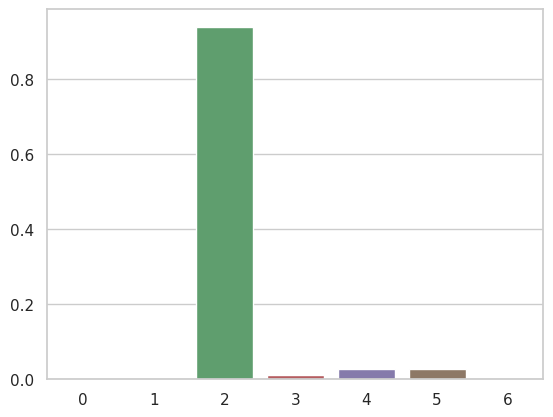

In [ ]:
import seaborn as sns
import numpy as np
sample = 9
sns.set_theme(style="whitegrid")
print(model(data.x, data.edge_index).shape)
pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w,h,-1))
    return rgba_arr


def visualize(h, color, epoch):
    fig = plt.figure(figsize=(5,5), frameon=False)
    fig.suptitle(f'Epoch = {epoch}')
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0],
                z[:, 1],
                s=70,
                c=color.detach().cpu().numpy(),
                cmap="Set2")
    fig.canvas.draw()
    return plt2arr(fig)
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

Visualizing the embeddings

TSNE Visualization finished.


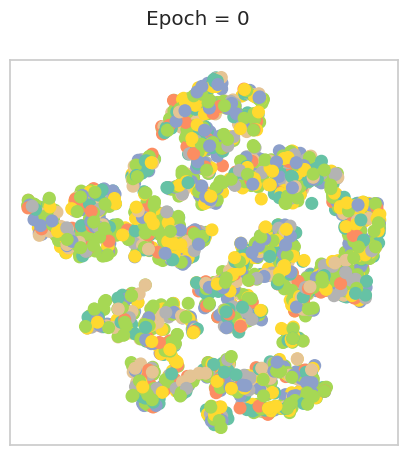

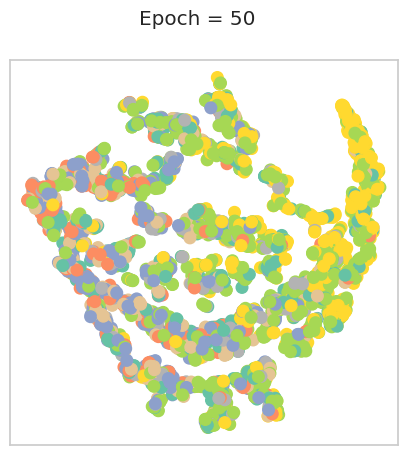

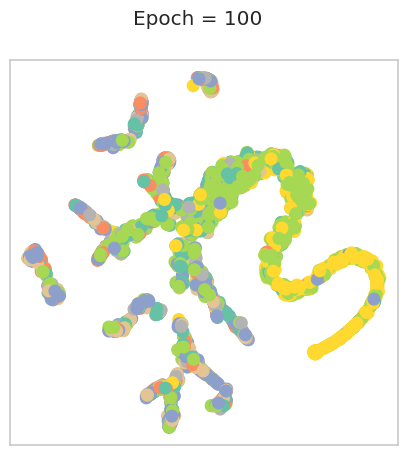

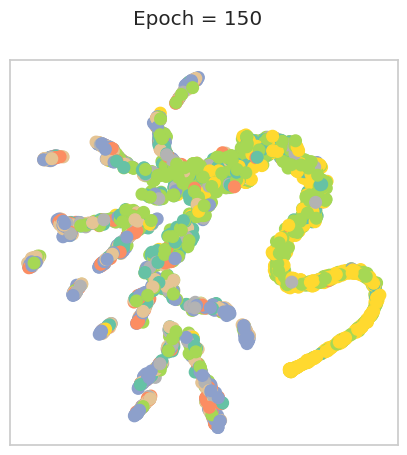

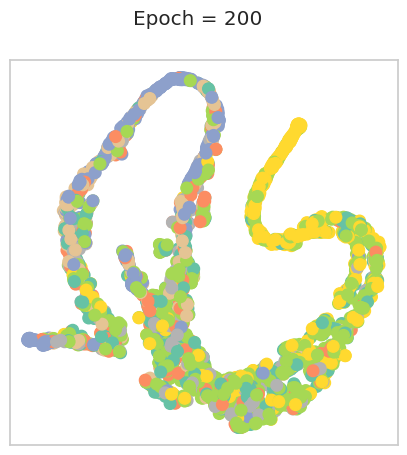

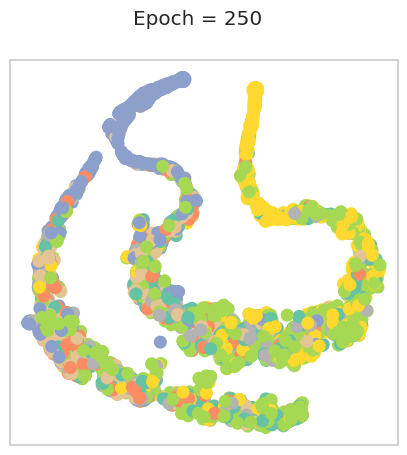

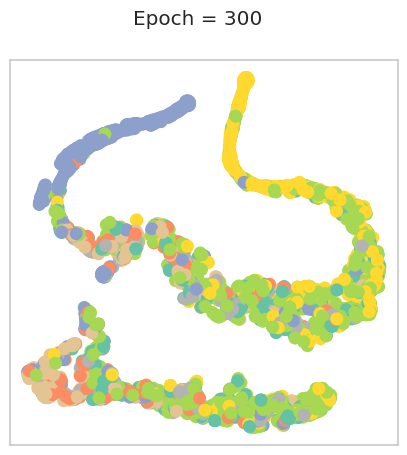

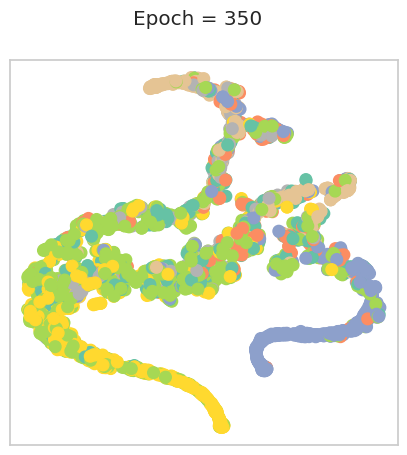

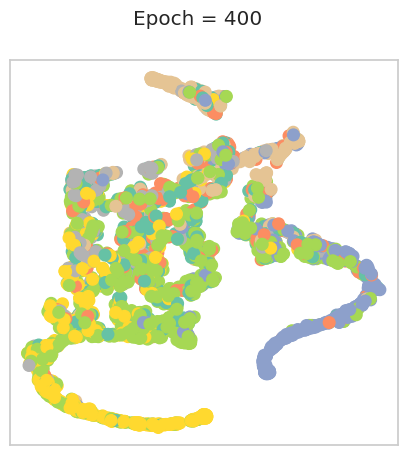

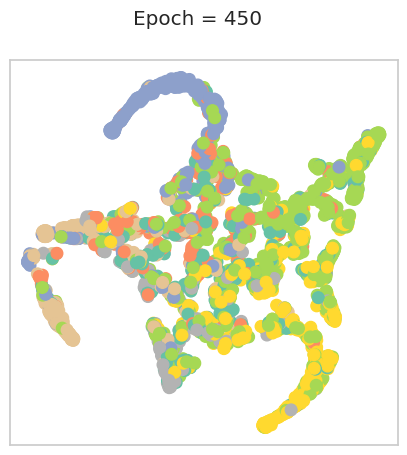

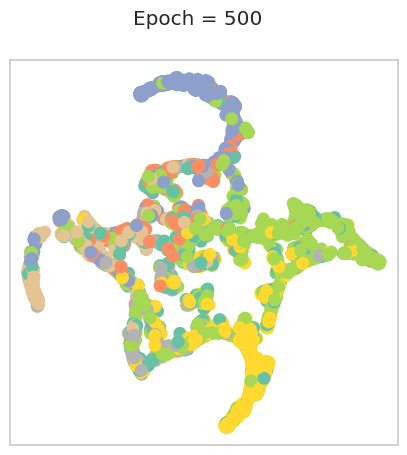

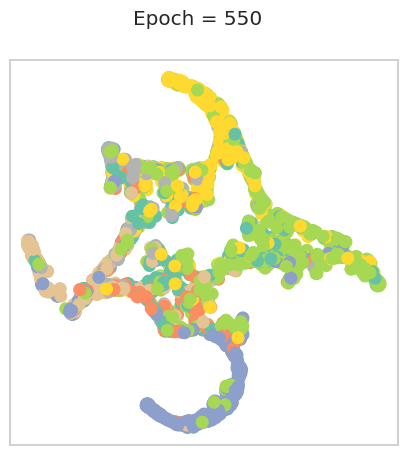

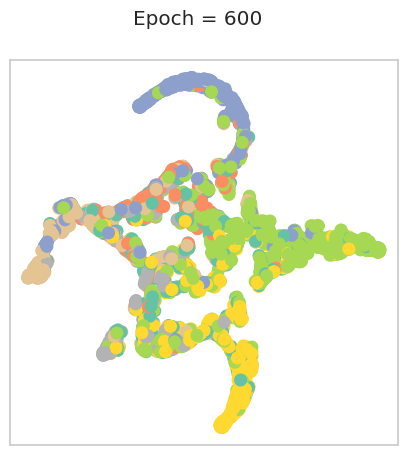

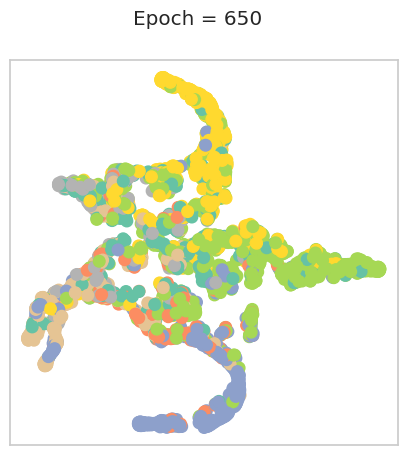

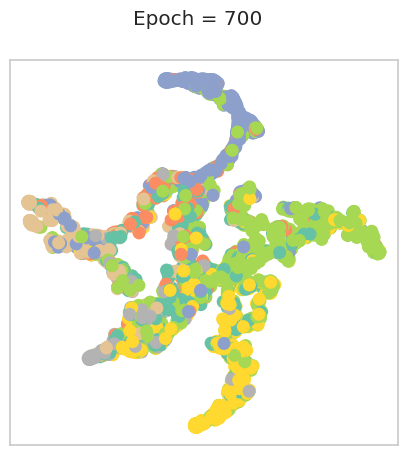

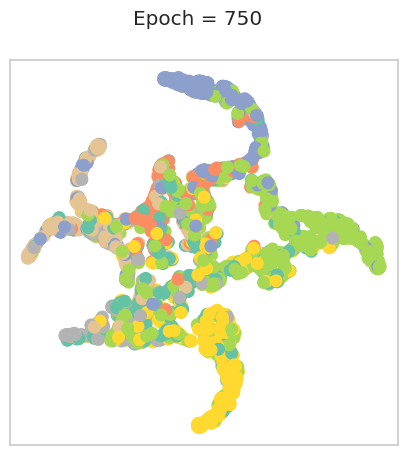

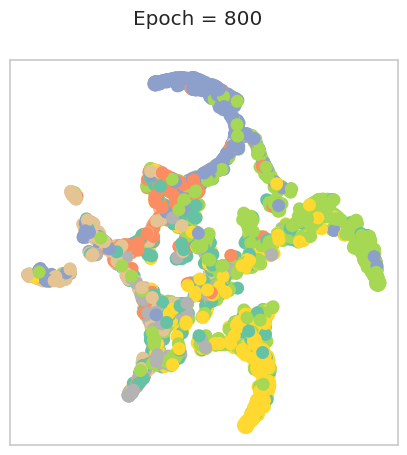

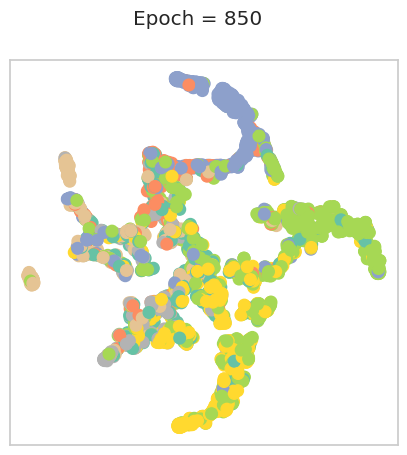

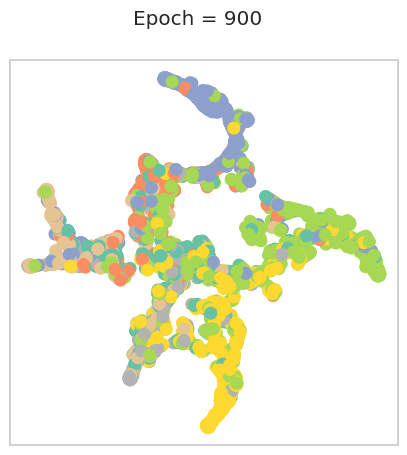

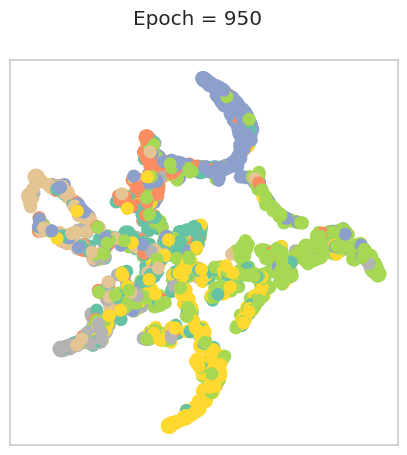

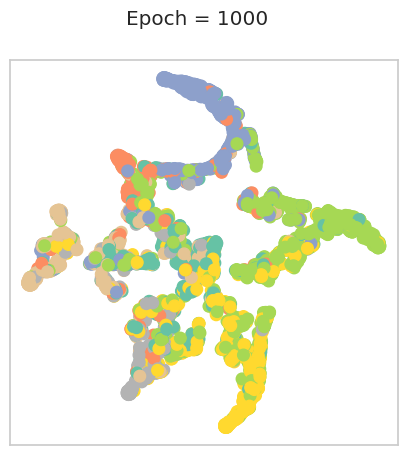

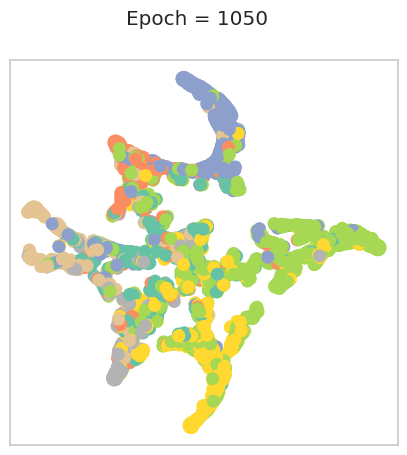

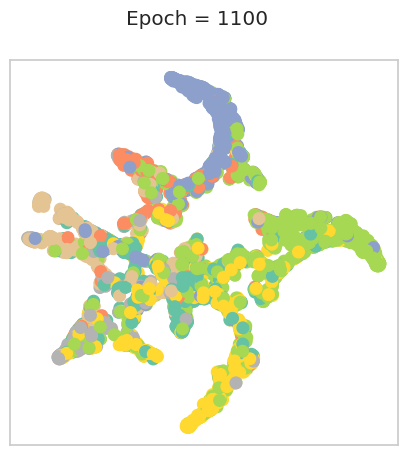

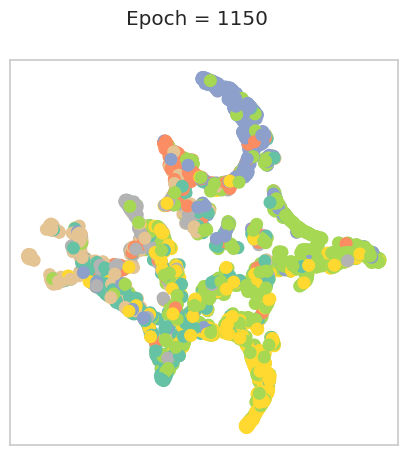

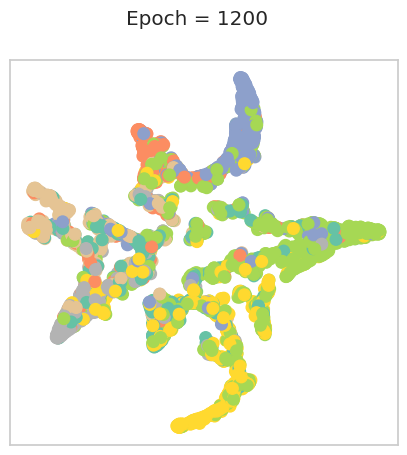

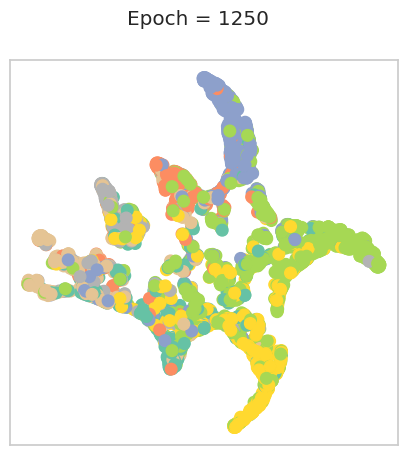

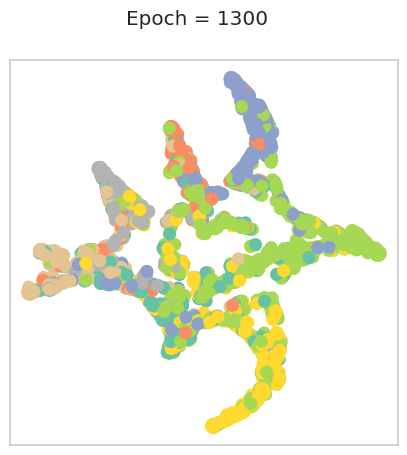

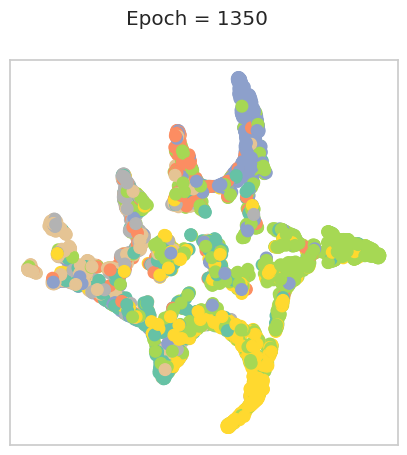

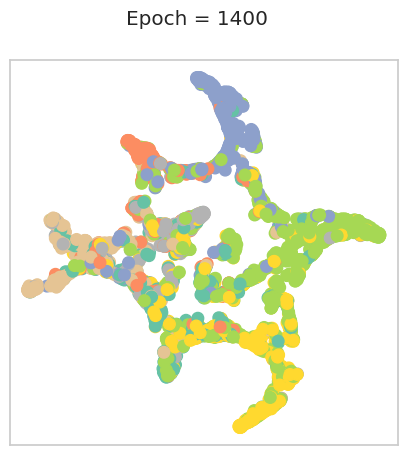

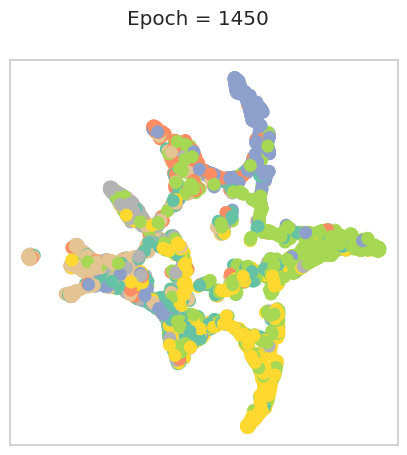

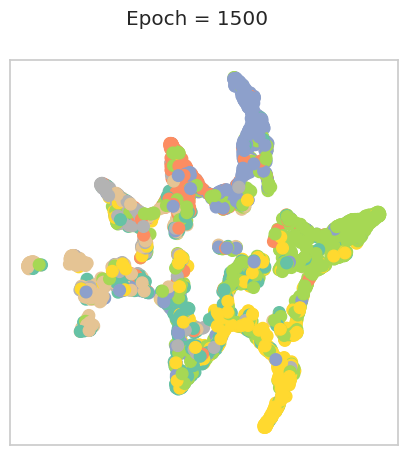

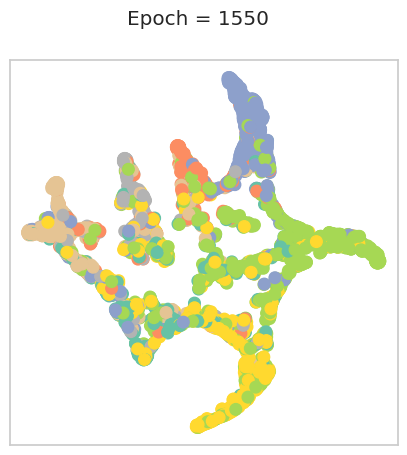

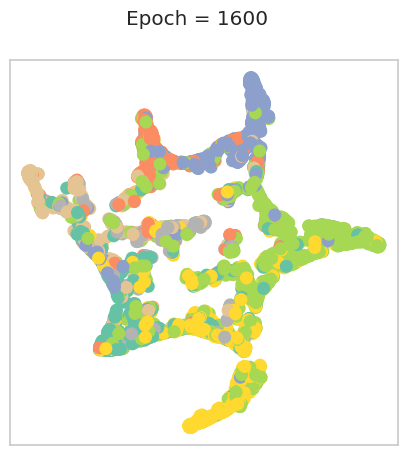

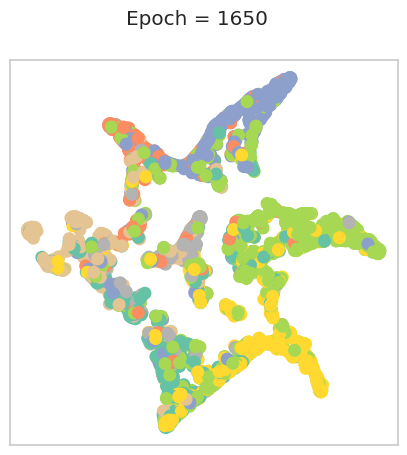

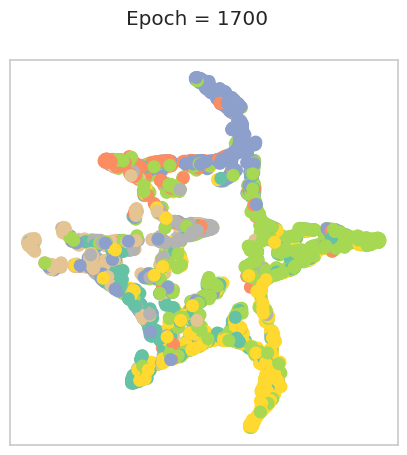

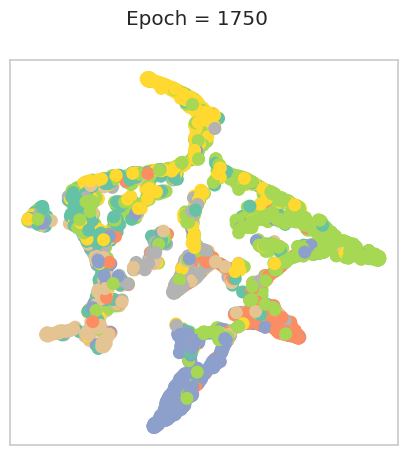

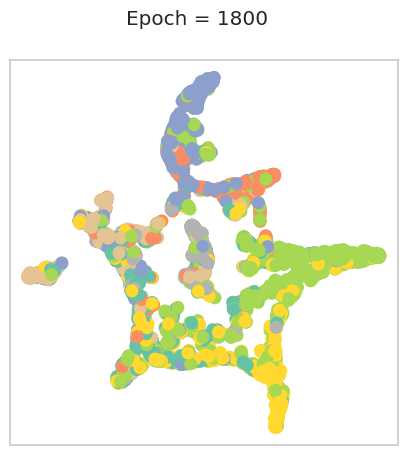

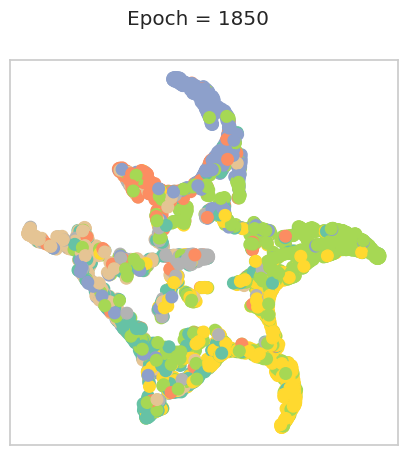

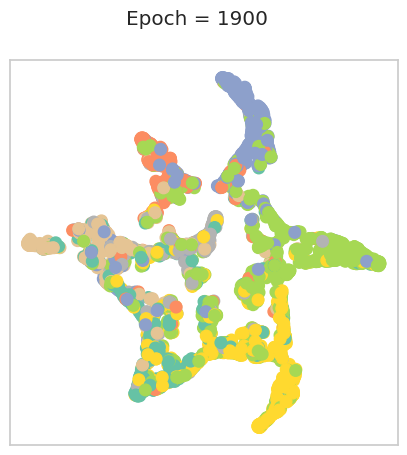

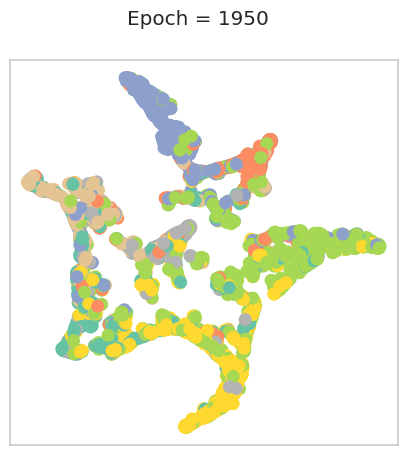

In [ ]:
import warnings
warnings.filterwarnings('ignore')
images = []
for epoch in range(0, 2000):
    loss = train()
    if epoch % 50 == 0:
      out = model(data.x, data.edge_index)
      images.append(visualize(out, color=data.y, epoch=epoch))
print("TSNE Visualization finished.")